In [1]:
%matplotlib inline

In [2]:
location="psi"

In [3]:
import sys

#add xgboost
sys.path += ["/mnt/t3nfs01/data01/shome/jpata/xgboost/python-package"]

import copy
from collections import OrderedDict

#add CMSCSTagger
if location=="jpata-macbook":
    sys.path.append("/Users/joosep/Documents/btv/CMSSW_7_4_5/src/RecoBTag/CombinedMVA/python/")
elif location=="psi":
    sys.path.append("/mnt/t3nfs01/data01/shome/jpata/btv/CMSSW_8_1_0/src/RecoBTag/CMSCSTagger/python/")

import numpy as np
import root_numpy as rnpy
import pandas
import dask

from matplotlib.colors import LogNorm
import rootpy
import rootpy.plotting

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold, ShuffleSplit

import ROOT

import matplotlib.pyplot as plt
import seaborn

import xgboost

import rootpy.plotting.root2matplotlib as rplt

#import the CMSCSTagger training library
import sklearn_cls

from pandas.tools.plotting import scatter_matrix

Welcome to ROOTaaS 6.06/08


/swshare/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
def calc_roc(h1, h2, rebin=1):
    h1 = h1.Clone()
    h2 = h2.Clone()
    h1.Rebin(rebin)
    h2.Rebin(rebin)

    if h1.Integral()>0:
        h1.Scale(1.0 / h1.Integral())
    if h2.Integral()>0:
        h2.Scale(1.0 / h2.Integral())
    roc = np.zeros((h1.GetNbinsX()+2, 2))
    err = np.zeros((h1.GetNbinsX()+2, 2))
    e1 = ROOT.Double(0)
    e2 = ROOT.Double(0)
    for i in range(0, h1.GetNbinsX()+2):
        I1 = h1.Integral(0, h1.GetNbinsX())
        I2 = h2.Integral(0, h2.GetNbinsX())
        if I1>0 and I2>0:
            roc[i, 0] = float(h1.IntegralAndError(i, h1.GetNbinsX()+2, e1)) / I1
            roc[i, 1] = float(h2.IntegralAndError(i, h2.GetNbinsX()+2, e2)) / I2
            err[i, 0] = e1
            err[i, 1] = e2
    return roc, err

In [5]:
seaborn.set_style("white")
current_palette = seaborn.color_palette()

Here we load the prepared training data.

In [6]:
vs = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMu", "Jet_SoftEl"]

In [7]:
fn = "/scratch/jpata/ttjets_tagvar_sub2000.root"
dd = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    fn,
    "tree_{0}".format(fl),
    branches=vs + ["Jet_flavour", "Jet_pt", "Jet_eta", "index", "Jet_cMVA"],
    #selection="index>=5"
    #start=0,
    #stop=500000
    )) for fl in ["b", "c", "l"]])
unique_classes = dd["flavour_category"].unique()

INFO:root:loading data from /scratch/jpata/ttjets_tagvar_sub2000.root:tree_b
INFO:root:loaded data with shape (5089981, 11)
INFO:root:memory usage: 0.71 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttjets_tagvar_sub2000.root:tree_c
INFO:root:loaded data with shape (3489471, 11)
INFO:root:memory usage: 1.14 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/j

In [8]:
fn = "/scratch/jpata/ttjets_tagvar_all.root"
dd2 = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    fn,
    "tree_{0}".format(fl),
    selection="index>=5",
    #start=0,
    #stop=2000000,
    branches=vs + ["Jet_flavour", "Jet_pt", "Jet_eta", "index", "Jet_cMVA"]
    )) for fl in ["b", "c", "l"]])

INFO:root:loading data from /scratch/jpata/ttjets_tagvar_all.root:tree_b
INFO:root:loaded data with shape (7783050, 11)
INFO:root:memory usage: 3.57 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttjets_tagvar_all.root:tree_c
INFO:root:loaded data with shape (2992288, 11)
INFO:root:memory usage: 4.22 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/ttj

In [9]:
dd["Jet_SoftMuSuppressed"] = dd["Jet_SoftMu"]
dd.loc[dd["Jet_pt"]>200, "Jet_SoftMuSuppressed"] = 0

In [10]:
dd2["Jet_SoftMuSuppressed"] = dd2["Jet_SoftMu"]
dd2.loc[dd2["Jet_pt"]>200, "Jet_SoftMuSuppressed"] = 0

In [11]:
vs2 = ["Jet_CSV", "Jet_CSVIVF", "Jet_JP", "Jet_JBP", "Jet_SoftMuSuppressed", "Jet_SoftEl"]

In [12]:
dd["flavour_category"].value_counts()

0    5303916
2    5089981
1    3489471
Name: flavour_category, dtype: int64

In [13]:
dd.shape

(13883368, 19)

In [14]:
dd["is_training"].value_counts()

True     12495032
False     1388336
Name: is_training, dtype: int64

Let's take a quick look at what we have.

In [15]:
dd.head()

,Jet_CSV,Jet_CSVIVF,Jet_JP,Jet_JBP,Jet_SoftMu,Jet_SoftEl,Jet_flavour,Jet_pt,Jet_eta,index,Jet_cMVA,flavour_category,is_training,weight,ptbin,ptbin2,etabin,etabin2,Jet_SoftMuSuppressed
0,0.996252,0.994214,1.215878,5.759959,0.592191,0.0,5.0,145.189285,0.229226,0,0.999791,2,True,1.0,3,10,1,1,0.592191
1,0.995961,0.995953,0.815291,3.754554,0.000000,0.0,5.0,89.784355,-0.138766,0,0.999618,2,True,1.0,2,7,1,1,0.000000
2,0.894669,0.889994,0.479402,2.033802,0.760045,0.0,5.0,143.867386,0.485237,1,0.982699,2,True,1.0,3,10,2,2,0.760045
3,0.134691,0.787586,0.889998,4.098591,0.000000,0.0,5.0,93.845192,-0.662428,2,0.383178,2,True,1.0,2,7,3,3,0.000000
4,0.901189,0.876131,0.710637,3.272606,0.000000,0.0,5.0,36.750057,1.373304,3,0.376972,2,True,1.0,1,2,6,6,0.000000


Now we calculate the kinematic weights.

In [16]:
weights_class = {
    fl: sklearn_cls.get_weights(dd.ix[dd["flavour_category"] == fl], sklearn_cls.ptbins, sklearn_cls.etabins)
    for fl in unique_classes
}

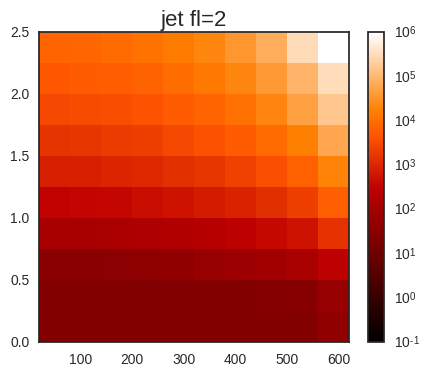

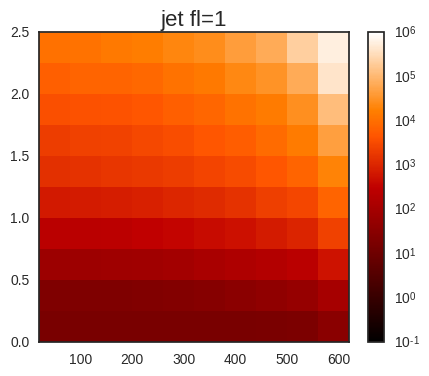

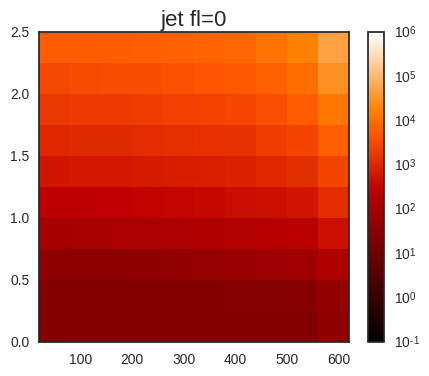

In [17]:
for fl in unique_classes:
    plt.figure(figsize=(5, 4))
    plt.title("jet fl={0}".format(fl), fontsize=16)
    z = plt.imshow(
        weights_class[fl],
        interpolation="none",
        origin="lower",
        norm=LogNorm(vmin=0.1,vmax=1000000.0),
        cmap="gist_heat",
        extent=(sklearn_cls.ptbins[0], sklearn_cls.ptbins[-1], sklearn_cls.etabins[0], sklearn_cls.etabins[-1]),
        aspect="auto"
    )
    plt.colorbar(z)
    #plt.xticks(ptbins)
    #plt.yticks(etabins)

In [18]:
def weight(pt, eta, fl, weights_class, ptbins, etabins):
    ibx = ptbins.searchsorted(pt) - 1
    iby = etabins.searchsorted(abs(eta)) - 1
    if ibx>=len(ptbins)-1:
        ibx = len(ptbins)-2
    if iby>=len(etabins)-1:
        iby = len(etabins)-2
        
    return weights_class[fl][ibx, iby]  

In [19]:
dd["weight"]  = map(
    lambda _z: weight(_z[0], _z[1], _z[2], weights_class, sklearn_cls.ptbins, sklearn_cls.etabins),
    zip(dd["Jet_pt"], dd["Jet_eta"].abs(), dd["flavour_category"])
)

In [20]:
def draw_corr(data, v1, vn1, v2, vn2, title):

    c = (np.abs(data["Jet_CSV"] -
         data["Jet_CSVIVF"])>0.00000000001
    )
    hd = np.histogram2d(
        data[c][v1],
        data[c][v2],
        bins=[np.linspace(0,1,21), np.linspace(0,1,21)]
    )
    hd = hd[0] / float(np.sum(hd[0]))
    corr = np.corrcoef(
        data[c][v1],
        data[c][v2]
    )

    plt.figure(figsize=(6,5))
    ax = plt.axes()
    ret = ax.imshow(
        hd,
        cmap="hot",
        interpolation="none",
        origin="lower",
        aspect="auto",
        #vmin=0,
        #vmax=60000,
        extent=[
            0,
            1,
            0,
            1
        ],
        norm=LogNorm(vmin=0.000001, vmax=1)
    )
    plt.title(title + " corr={0:.4f}".format(corr[0,1]), fontsize=16)
    plt.xlabel(vn1, fontsize=16)
    plt.ylabel(vn2, fontsize=16)
    plt.colorbar(ret)

Pt distribution before and after reweighting.

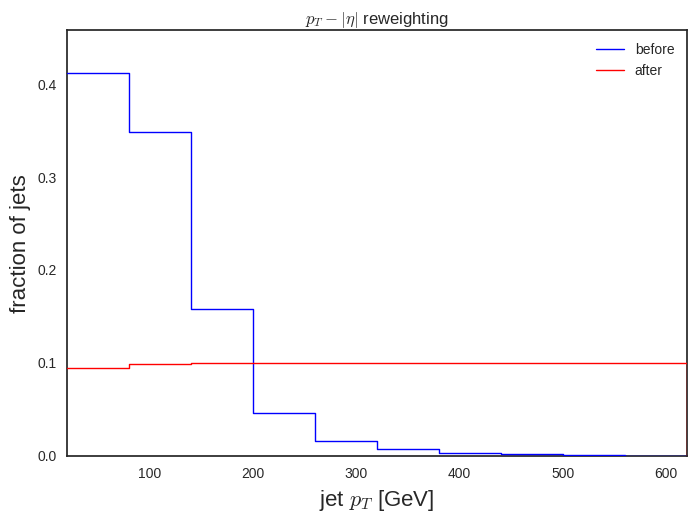

In [21]:
h = rootpy.plotting.Hist(sklearn_cls.ptbins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.ptbins)
h2.FillN(len(dd), np.array(dd["Jet_pt"]).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $p_T$ [GeV]", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("pt_reweight.pdf")

Eta distribution before and after reweighting.

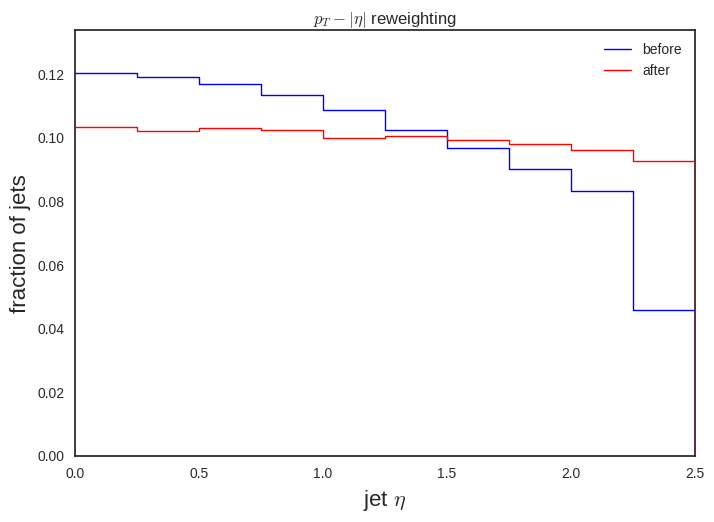

In [22]:
h = rootpy.plotting.Hist(sklearn_cls.etabins)
w = np.ones(len(dd), dtype="float64")
h.FillN(len(dd), np.array(dd["Jet_eta"].abs()).astype("float64"), w)
h.Scale(1.0 / h.Integral())
h.color="blue"
rplt.hist(h, color="blue", label="before")

h2 = rootpy.plotting.Hist(sklearn_cls.etabins)
h2.FillN(len(dd), np.array(dd["Jet_eta"].abs()).astype("float64"), np.array(dd["weight"]).astype("float64"))
h2.Scale(1.0 / h2.Integral())
h2.color="red"
rplt.hist(h2, color="red", label="after")

#plt.yscale("log")
#plt.ylim(10**-5, 1)
plt.xlabel("jet $\eta$", fontsize=16)
plt.ylabel("fraction of jets", fontsize=16)
plt.legend()
plt.title("$p_T-|\eta|$ reweighting")
plt.savefig("eta_reweight.pdf")

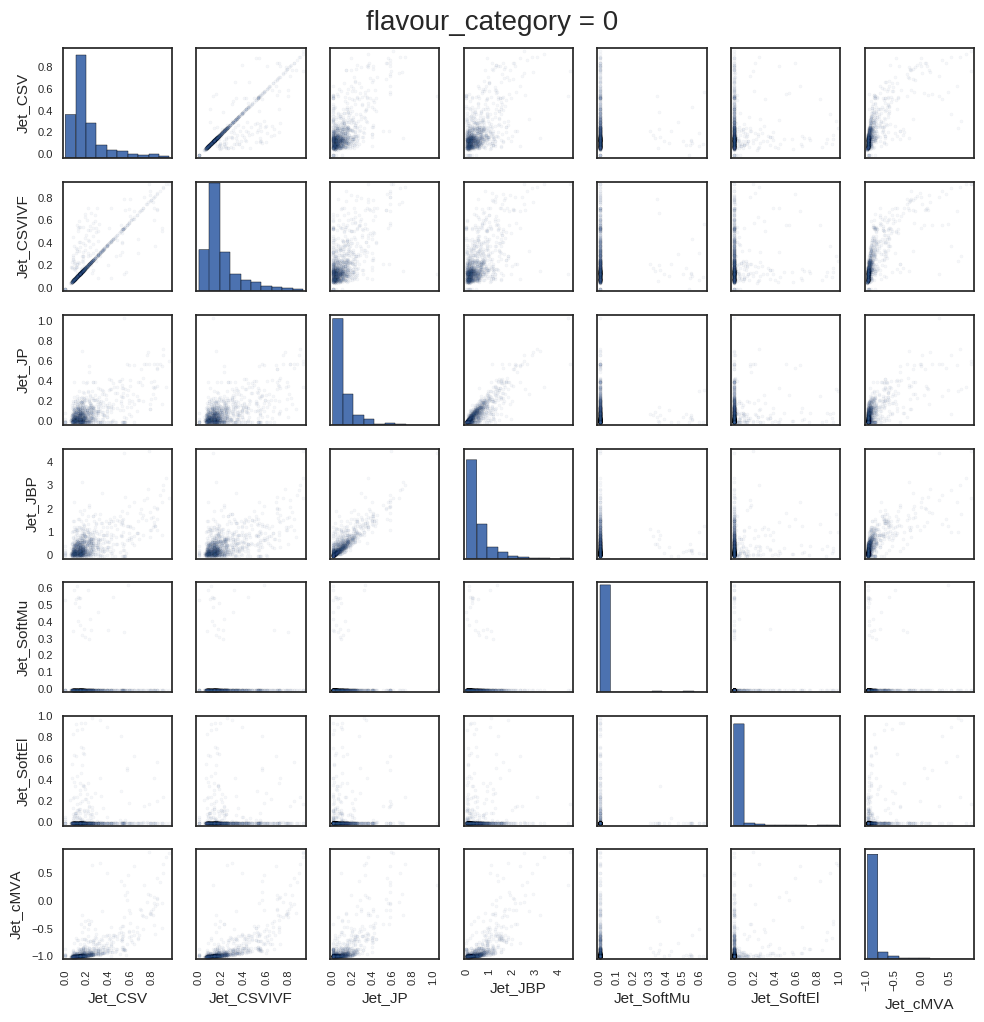

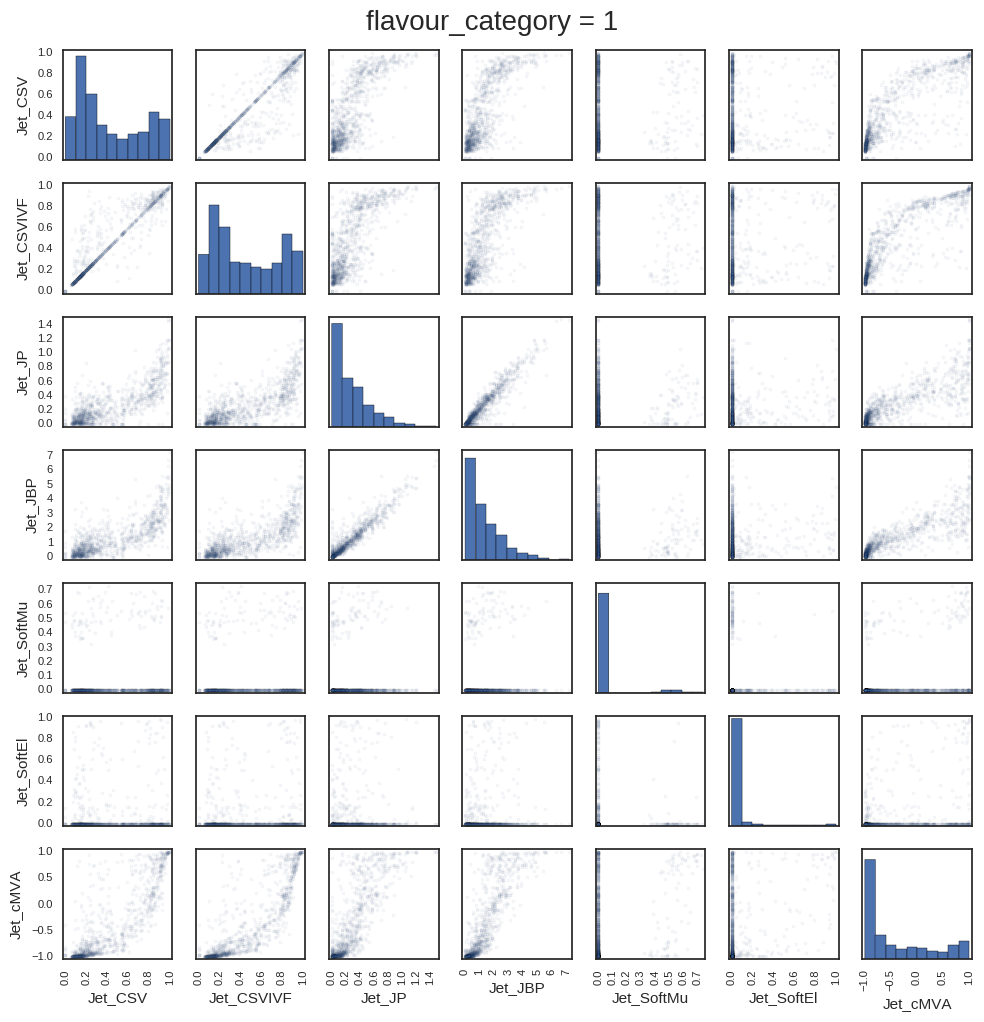

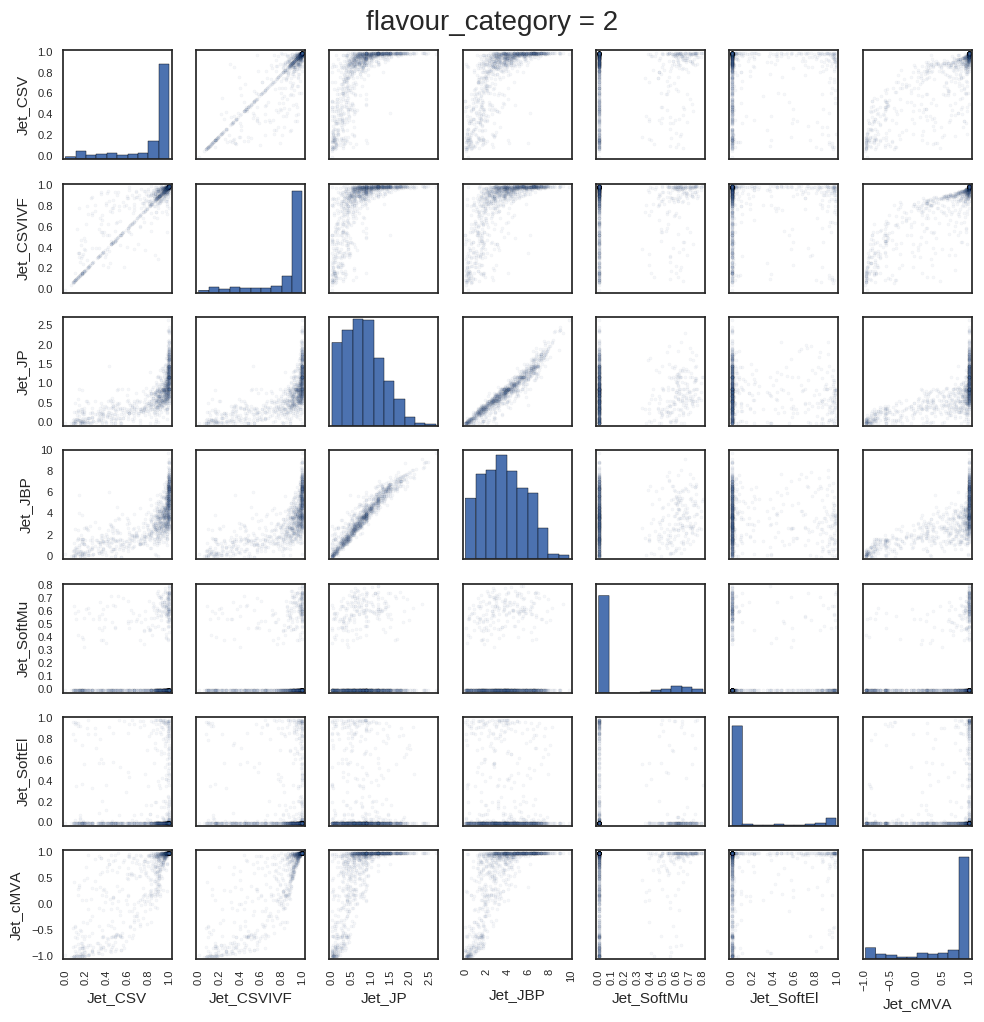

In [23]:
for igroup, (name, group) in enumerate(dd.groupby("flavour_category")):
    scatter_matrix(group.head(1000)[vs + ["Jet_cMVA"]], alpha=0.05, figsize=(10, 10), diagonal='hist')
    seaborn.plt.suptitle("flavour_category = {0}".format(name), fontsize=20, y=1.02)
    seaborn.plt.tight_layout()

In [24]:
is_training = dd2["is_training"]==1
eval_set = [
    #training set, ttjets
    (dd2.ix[is_training, vs], dd2.ix[is_training, "flavour_category"]==2, dd2.ix[is_training, "weight"]),
    #testing set
    (dd2.ix[np.invert(is_training), vs], dd2.ix[np.invert(is_training), "flavour_category"]==2, dd2.ix[np.invert(is_training), "weight"])
]

eval_set2 = [
    #training set, ttjets
    (dd2.ix[is_training, vs2], dd2.ix[is_training, "flavour_category"]==2, dd2.ix[is_training, "weight"]),
    #testing set
    (dd2.ix[np.invert(is_training), vs2], dd2.ix[np.invert(is_training), "flavour_category"]==2, dd2.ix[np.invert(is_training), "weight"])
]

In [25]:
dd2.groupby(["flavour_category", "is_training"]).apply(lambda x: len(x))

flavour_category  is_training
0                 False          2426379
                  True           9705517
1                 False           598457
                  True           2393831
2                 False          1556610
                  True           6226440
dtype: int64

In [26]:
dd2.groupby(["flavour_category", "is_training"]).apply(lambda x: len(x))

flavour_category  is_training
0                 False          2426379
                  True           9705517
1                 False           598457
                  True           2393831
2                 False          1556610
                  True           6226440
dtype: int64

In [94]:
cls = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, nthread=32)
cls2 = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, nthread=32)
cls3 = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, nthread=32, max_depth=4)

In [ ]:
res = cls.fit(eval_set[0][0], eval_set[0][1], eval_set[0][2], eval_set=eval_set, eval_metric=["error"], verbose=False)

In [ ]:
cls3.fit(eval_set[0][0], eval_set[0][1], eval_set[0][2], eval_set=eval_set, eval_metric=["error"], verbose=False)

In [ ]:
cls2.fit(eval_set2[0][0], eval_set2[0][1], eval_set2[0][2], eval_set=eval_set2, eval_metric=["error"], verbose=False)

In [ ]:
dd["cls_p1"] = cls.predict_proba(dd[vs])[:, 1]
dd["cls_p2"] = cls2.predict_proba(dd[vs2])[:, 1]
dd["cls_p3"] = cls3.predict_proba(dd[vs])[:, 1]

In [ ]:
dd2["cls_p1"] = cls.predict_proba(dd2[vs])[:, 1]
dd2["cls_p2"] = cls2.predict_proba(dd2[vs2])[:, 1]
dd2["cls_p3"] = cls3.predict_proba(dd2[vs2])[:, 1]

In [32]:
b_vs_udsg = dd["flavour_category"] != 1
b_vs_c = dd["flavour_category"] != 0

In [63]:
def hist_from_array(arr, bins):
    h = rootpy.plotting.Hist(*bins)
    weights = np.ones(len(arr), dtype=np.double)
    h.FillN(len(arr), arr.astype(np.double), weights)
    h.SetBinContent(1, h.GetBinContent(0) + h.GetBinContent(1))
    h.SetBinContent(0, 0)
    
    h.SetBinContent(h.GetNbinsX(), h.GetBinContent(h.GetNbinsX()) + h.GetBinContent(h.GetNbinsX() + 1))
    h.SetBinContent(h.GetNbinsX()+1, 0)
    
    return h

In [64]:
def get_hists(dd, cut, var, bins):
    h1b = hist_from_array(dd[(dd["flavour_category"] == 2) & cut][var].as_matrix(), bins)
    h1c = hist_from_array(dd[(dd["flavour_category"] == 1) & cut][var].as_matrix(), bins)
    h1u = hist_from_array(dd[(dd["flavour_category"] == 0) & cut][var].as_matrix(), bins)
    return h1b, h1c, h1u

In [65]:
h1b, h1c, h1u = get_hists(dd, dd["is_training"]==0, "cls_p1", (100, 0, 1))

In [66]:
h2b, h2c, h2u = get_hists(dd, dd["is_training"]==1, "cls_p1", (100, 0, 1))

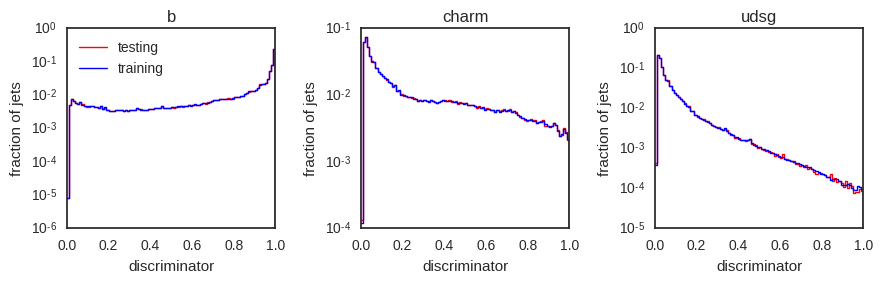

In [67]:
for h in [h1b, h2b, h1c, h2c, h1u, h2u]:
    h.Scale(1.0/h.Integral())

plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
rplt.step(h1b, color="red", label="testing")
rplt.step(h2b, color="blue", label="training")
plt.xlabel("discriminator")
plt.ylabel("fraction of jets")
plt.title("b")
plt.yscale("log")
plt.legend(loc="best")

plt.subplot(1,3,2)
rplt.step(h1c, color="red")
rplt.step(h2c, color="blue")
plt.xlabel("discriminator")
plt.ylabel("fraction of jets")
plt.title("charm")
plt.yscale("log")

plt.subplot(1,3,3)
rplt.step(h1u, color="red")
rplt.step(h2u, color="blue")
plt.xlabel("discriminator")
plt.ylabel("fraction of jets")
plt.title("udsg")
plt.yscale("log")

plt.tight_layout()

In [68]:
hb, hc, hu = get_hists(dd2, dd2["index"]>=0, "cls_p1", (1000, 0, 1))
hb2, hc2, hu2 = get_hists(dd2, dd2["index"]>=0, "cls_p2", (1000, 0, 1))
hb_csv, hc_csv, hu_csv = get_hists(dd2, dd2["index"]>=0, "Jet_CSVIVF", (1000, 0, 1))
hb_cmva, hc_cmva, hu_cmva = get_hists(dd2, dd2["index"]>=0, "Jet_cMVA", (2000, -1, 1))

In [69]:
ru1, e = calc_roc(hb, hu)
rc1, e = calc_roc(hb, hc)

ru4, e = calc_roc(hb2, hu2)
rc4, e = calc_roc(hb2, hc2)

ru2, e = calc_roc(hb_csv, hu_csv)
rc2, e = calc_roc(hb_csv, hc_csv)

ru3, e = calc_roc(hb_cmva, hu_cmva)
rc3, e = calc_roc(hb_cmva, hc_cmva)

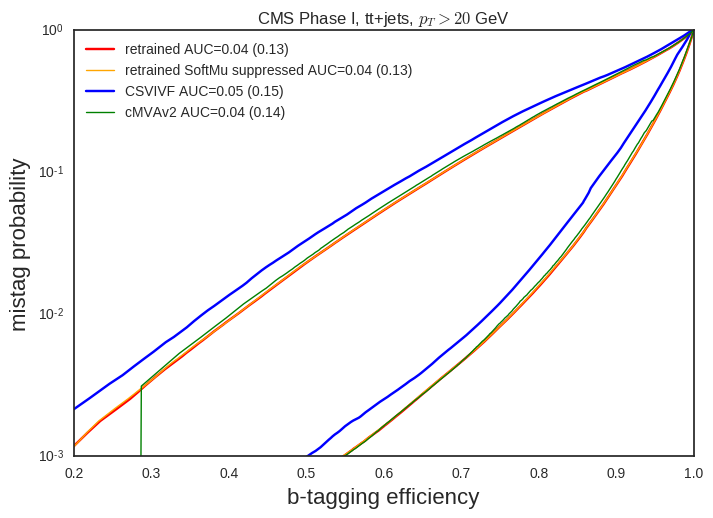

In [70]:
plt.plot(ru1[:, 0], ru1[:, 1], color="red", label="retrained AUC={0:.2f} ({1:.2f})".format(
    sklearn.metrics.auc(ru1[:, 0], ru1[:, 1]),
    sklearn.metrics.auc(rc1[:, 0], rc1[:, 1])
))
plt.plot(rc1[:, 0], rc1[:, 1], color="red")

plt.plot(ru4[:, 0], ru4[:, 1], color="orange", lw=1, label="retrained SoftMu suppressed AUC={0:.2f} ({1:.2f})".format(
    sklearn.metrics.auc(ru4[:, 0], ru4[:, 1]),
    sklearn.metrics.auc(rc4[:, 0], rc4[:, 1])
))
plt.plot(rc4[:, 0], rc4[:, 1], color="orange", lw=1)

plt.plot(ru2[:, 0], ru2[:, 1], color="blue", label="CSVIVF AUC={0:.2f} ({1:.2f})".format(
    sklearn.metrics.auc(ru2[:, 0], ru2[:, 1]),
    sklearn.metrics.auc(rc2[:, 0], rc2[:, 1])
))
plt.plot(rc2[:, 0], rc2[:, 1], color="blue")

plt.plot(ru3[:, 0], ru3[:, 1], color="green", lw=1, label="cMVAv2 AUC={0:.2f} ({1:.2f})".format(
    sklearn.metrics.auc(ru3[:, 0], ru3[:, 1]),
    sklearn.metrics.auc(rc3[:, 0], rc3[:, 1])
))
plt.plot(rc3[:, 0], rc3[:, 1], color="green", lw=1)

plt.yscale("log")
plt.xlim(0.2,1.0)
plt.ylim(0.001, 1.0)
plt.legend(loc=2)
plt.xlabel("b-tagging efficiency", fontsize=16)
plt.ylabel("mistag probability", fontsize=16)
plt.title("CMS Phase I, tt+jets, $p_T > 20$ GeV")

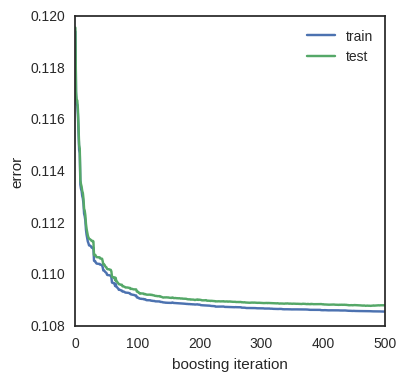

In [71]:
plt.figure(figsize=(4,4))
plt.plot(cls.evals_result_["validation_0"]["error"], label="train")
plt.plot(cls.evals_result_["validation_1"]["error"], label="test")
plt.legend()
plt.xlabel("boosting iteration")
plt.ylabel("error")

In [72]:
#rets_cv = sklearn_cls.train_crossvalidation(cls, eval_set[0])

In [73]:
# plt.figure(figsize=(4,4))
# for tpr, fpr in rets_cv:
#     plt.plot(tpr, fpr, color="black", lw=1, alpha=0.3)
# plt.plot(tpr_main, fpr_main, color="black", lw=2)
# aucs = np.array([sklearn.metrics.auc(tpr, fpr) for (tpr, fpr) in rets_cv])
# print aucs
# plt.title("AUC\nmean={0:.4E}\nstd={1:.4E}".format(np.mean(aucs), np.std(aucs)))
# plt.yscale("log")
# plt.xlim(0.5, 1.0)
# plt.ylim(0.01, 1.0)

In [74]:
# rets_varremove = sklearn_cls.train_variable_remove(cls, eval_set[0], eval_set[1])

In [75]:
# plt.figure(figsize=(6,6))
# plt.title("discrimination with removing one variable")
# for (tpr, fpr), var in zip(rets_varremove[0], rets_varremove[1]):
#     plt.plot(tpr, fpr, label="{0} AUC={1:.4f}".format(var, sklearn.metrics.auc(tpr, fpr)), lw=1)

# # plt.plot(
# #     tpr_main,
# #     fpr_main,
# #     color="black",
# #     lw=2,
# #     label="{0} AUC={1:.4f}".format(
# #         "total", sklearn.metrics.auc(tpr_main, fpr_main))
# #     )
# plt.yscale("log")
# plt.xlim(0.5, 1.0)
# plt.ylim(0.01, 1.0)
# ts = np.logspace(-2, 0, 21)
# plt.yticks(ts, [round(x, 3) for x in ts])
# plt.legend(loc="best")

In [76]:
def get_auc_by_group(dd2, c1, c2, discs, col):
    """
    c1 (int): first category, e.g. signal
    c2 (int): second category, e.g. background
    discs (list of strings): discriminators to plot
    col (string): column to split on
    """
    vals = {d: [] for d in discs}
    vals_err = {d: [] for d in discs}
    for grname, gr in dd2.groupby(col):
        vals_bin = {d: [] for d in discs}
        
        #randomly select subsample of events to calculate metric on
        kf = ShuffleSplit(n_splits = 5)
        
        shuf_index = np.random.permutation(gr.index)
        
        for train, test in kf.split(shuf_index):
            for disc in discs:
                mask = np.zeros(len(gr), dtype=np.bool)
                mask[train] = True
                ha = hist_from_array(gr[(gr["flavour_category"] == c1) & mask][disc].as_matrix(), (1000, -1, 1))
                hb = hist_from_array(gr[(gr["flavour_category"] == c2) & mask][disc].as_matrix(), (1000, -1, 1))
                ru, e = calc_roc(ha, hb)
                vals_bin[disc] += [sklearn.metrics.auc(ru[:, 0], ru[:, 1])]
        for d in discs:
            vals[d] += [np.mean(vals_bin[d])]
            vals_err[d] += [np.std(vals_bin[d])]
    return vals, vals_err

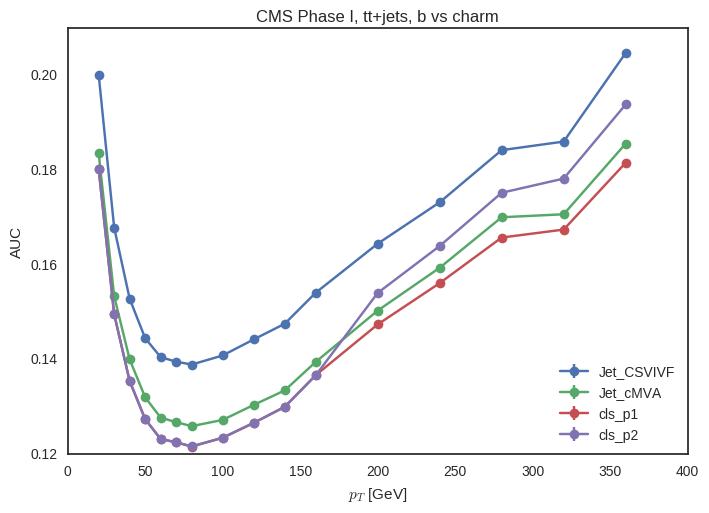

In [77]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd2, 2, 1, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("AUC")
plt.title("CMS Phase I, tt+jets, b vs charm")

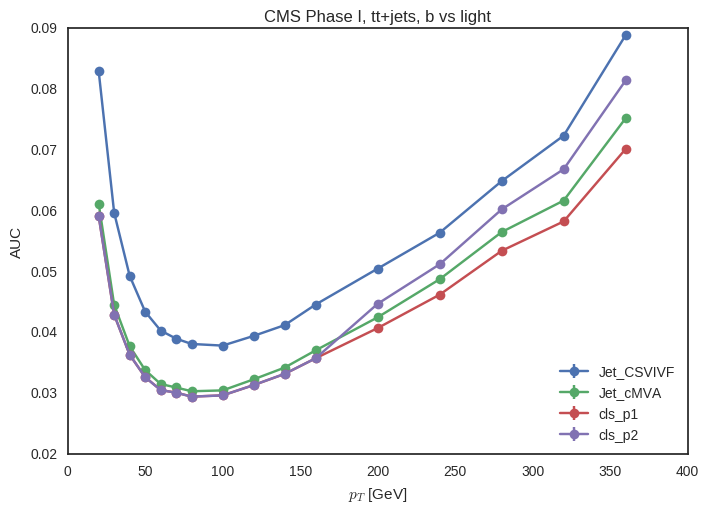

In [78]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd2, 2, 0, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("AUC")
plt.title("CMS Phase I, tt+jets, b vs light")

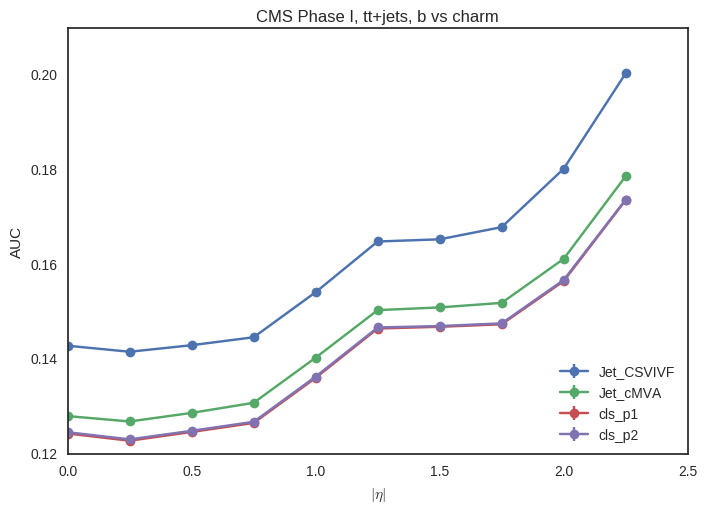

In [79]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd2, 2, 1, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2[:-1], vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$|\eta|$")
plt.ylabel("AUC")
plt.title("CMS Phase I, tt+jets, b vs charm")

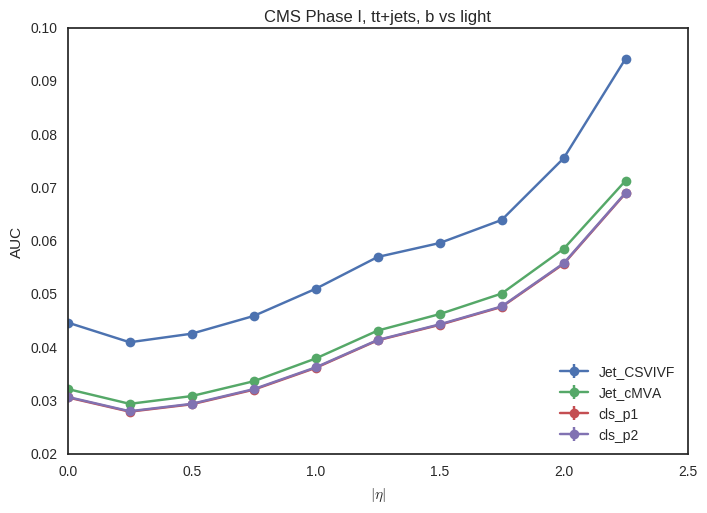

In [80]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd2, 2, 0, discs, "etabin2")
for d in discs:
    plt.errorbar(sklearn_cls.etabins2[:-1], vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$|\eta|$")
plt.ylabel("AUC")
plt.title("CMS Phase I, tt+jets, b vs light")

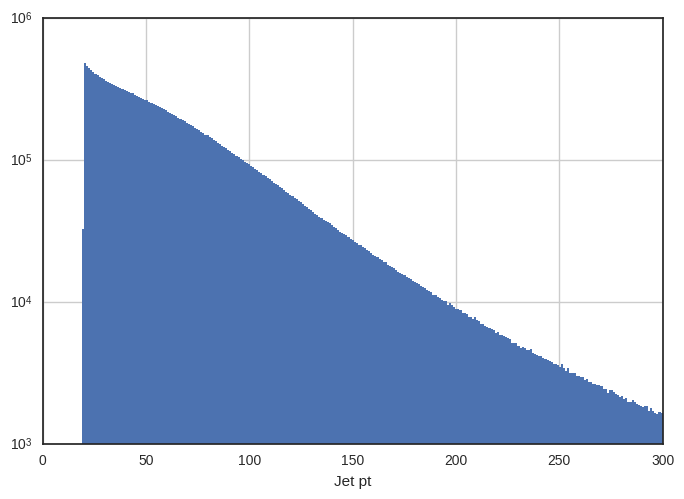

In [81]:
dd2["Jet_pt"].hist(bins=np.linspace(0, 300, 300), lw=0)
plt.yscale("log")
plt.xlabel("Jet pt")

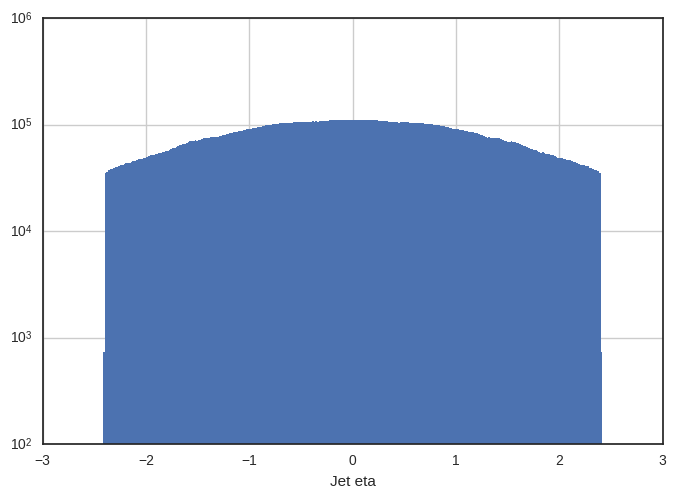

In [82]:
dd2["Jet_eta"].hist(bins=np.linspace(-2.5, 2.5, 300), lw=0)
plt.yscale("log")
plt.xlabel("Jet eta")

In [83]:
fn3 = "/scratch/jpata/qcd_tagvar_all.root"
dd3 = pandas.concat([sklearn_cls.preprocess(sklearn_cls.load_data(
    fn3,
    "tree_{0}".format(fl),
    #selection="index>=8",
    start=0,
    stop=1000000,
    branches=vs + ["Jet_flavour", "Jet_pt", "Jet_eta", "index", "Jet_cMVA"]
)) for fl in ["b", "c", "l"]])

INFO:root:loading data from /scratch/jpata/qcd_tagvar_all.root:tree_b
INFO:root:loaded data with shape (1000000, 11)
INFO:root:memory usage: 24.65 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/qcd_tagvar_all.root:tree_c
INFO:root:loaded data with shape (1000000, 11)
INFO:root:memory usage: 24.65 MB
INFO:root:preprocessing data
DEBUG:root:normalize_col_inplace Jet_CSV
DEBUG:root:normalize_col_inplace Jet_CSVIVF
DEBUG:root:normalize_col_inplace Jet_JP
DEBUG:root:normalize_col_inplace Jet_JBP
DEBUG:root:normalize_col_inplace Jet_SoftMu
DEBUG:root:normalize_col_inplace Jet_SoftEl
DEBUG:root:normalize_col_inplace Jet_cMVA
INFO:root:loading data from /scratch/jpata/qcd_tag

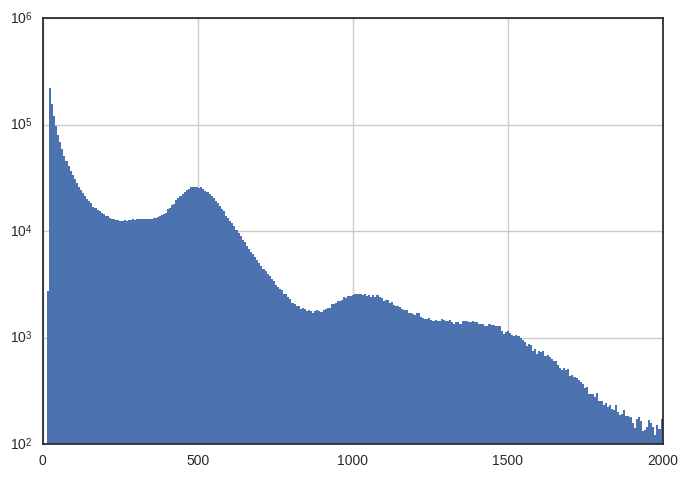

In [84]:
dd3["Jet_pt"].hist(bins=np.linspace(0, 2000, 300), lw=0)
plt.yscale("log")

In [85]:
dd3["Jet_SoftMuSuppressed"] = dd3["Jet_SoftMu"]
dd3.loc[dd3["Jet_pt"]>200, "Jet_SoftMuSuppressed"] = 0

In [86]:
dd3[vs].head()

,Jet_CSV,Jet_CSVIVF,Jet_JP,Jet_JBP,Jet_SoftMu,Jet_SoftEl
0,0.887920,0.665186,0.351298,1.936674,0.0,0.0
1,0.331959,0.331959,-0.000000,0.700647,0.0,0.0
2,0.907575,0.945636,0.360794,3.419726,0.0,0.0
3,0.284171,0.624439,0.332448,2.149358,0.0,0.0
4,0.740293,0.860116,0.342623,1.577836,0.0,0.0


In [87]:
dd3["cls_p1"] = cls.predict_proba(dd3[vs])[:, 1]
dd3["cls_p2"] = cls2.predict_proba(dd3[vs2])[:, 1]

In [88]:
hb, hc, hu = get_hists(dd3, dd3["index"]>=0, "cls_p1", (1000, 0, 1))
hb2, hc2, hu2 = get_hists(dd3, dd3["index"]>=0, "cls_p2", (1000, 0, 1))
hb_csv, hc_csv, hu_csv = get_hists(dd3, dd3["index"]>=0, "Jet_CSVIVF", (1000, 0, 1))
hb_cmva, hc_cmva, hu_cmva = get_hists(dd3, dd3["index"]>=0, "Jet_cMVA", (1000, -1, 1))

In [89]:
ptbins3 = np.logspace(1, 4, 11)

In [90]:
dd3["ptbin3"] = map(lambda x: ptbins3.searchsorted(x), dd3["Jet_pt"])

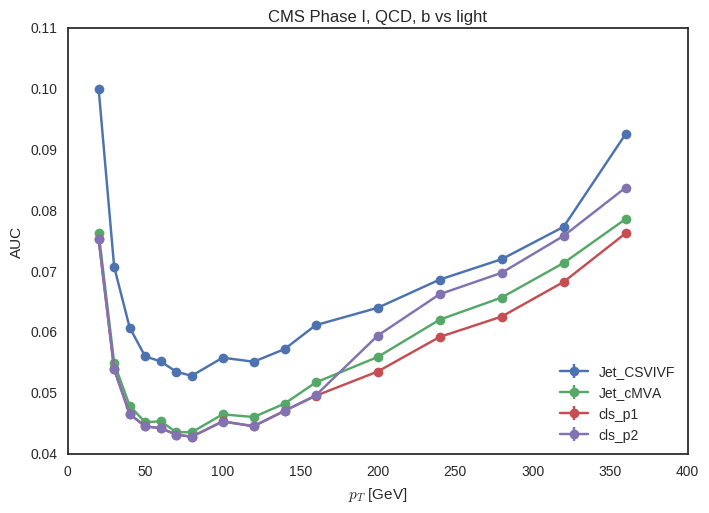

In [91]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd3, 2, 0, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("AUC")
plt.title("CMS Phase I, QCD, b vs light")

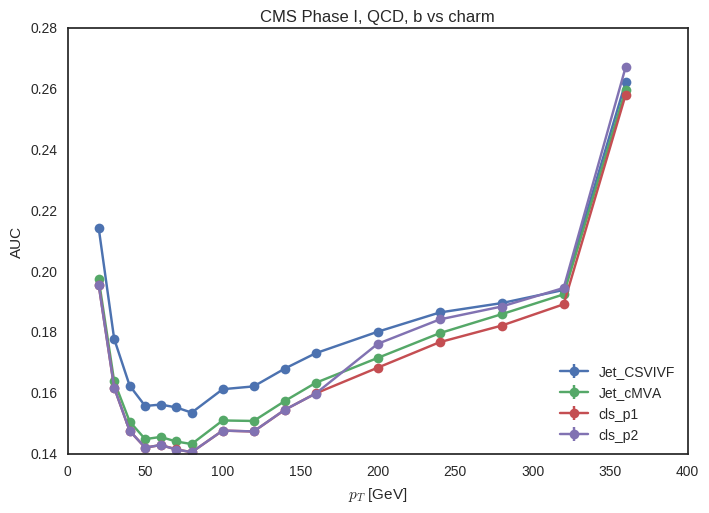

In [92]:
discs = ["Jet_CSVIVF", "Jet_cMVA", "cls_p1", "cls_p2"]
vals, vals_err = get_auc_by_group(dd3, 2, 1, discs, "ptbin2")
for d in discs:
    plt.errorbar(sklearn_cls.ptbins2, vals[d], yerr=vals_err[d], label=d, marker="o")
plt.legend(loc=4)
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("AUC")
plt.title("CMS Phase I, QCD, b vs charm")